In [1]:
from fastai2.vision.all import *
from collections import Counter
import librosa
import seaborn as sns

## Downloading the data

In [2]:
path = untar_data('https://storage.googleapis.com/ml-animal-sounds-datasets/zebra_finch.zip')

## Read in the data and establish a simple way of providing it to a deep learning model

In [3]:
path.ls()

(#2) [Path('/home/radek/workspace/esp_library/zebra_finch/data/zebra_finch/vocalizations'),Path('/home/radek/workspace/esp_library/zebra_finch/data/zebra_finch/annotations.csv')]

In [4]:
df = pd.read_csv(path / 'annotations.csv')

In [5]:
srs, recs = [], []
for p in (path/'vocalizations').ls():
    x, sr = librosa.load(p, sr=None)
    srs.append(sr)
    recs.append(x)

In [6]:
Counter(srs) # all files use 44.1kHz sampling rate

Counter({44100: 3405})

In [7]:
durations = mapped(lambda x: x.shape[0] / 44100, recs)

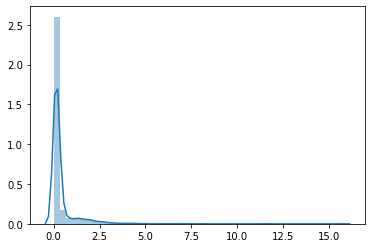

In [8]:
sns.distplot(durations)

In [9]:
np.median(durations) # 50% of recordings are under 0.153 second

0.15303854875283446

In [10]:
x, _ = librosa.load((path/'vocalizations').ls()[0], sr=None)

In [11]:
rate = 44100
num_frames = int(0.15 * rate)

In [16]:
x = librosa.util.fix_length(x, num_frames)
spec = librosa.feature.melspectrogram(x, sr=rate, n_fft=1024, hop_length=50)

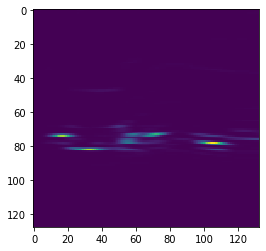

In [17]:
plt.imshow(spec)

#### Putting it all together to create a fastai DataBlock

In [18]:
def get_x(row):
    x, _ = librosa.load(path/'vocalizations'/row.fn, sr=None)
    x = librosa.util.fix_length(x, num_frames)
    spec = librosa.feature.melspectrogram(x, sr=rate, n_fft=1024, hop_length=50)
    spec = spec / spec.max() * 255 # we want the range of values for our data to be [0, 255]
                                   # this way fastai internally will be able to represent it as an image using PIL
    return spec.astype(np.uint8)

In [19]:
def get_y(row): return row.call_type

In [20]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x = get_x,
    get_y = get_y,
    splitter = TrainTestSplitter(test_size=0.1, random_state=42, stratify=df.call_type)
)

dls = db.dataloaders(df, bs=128)

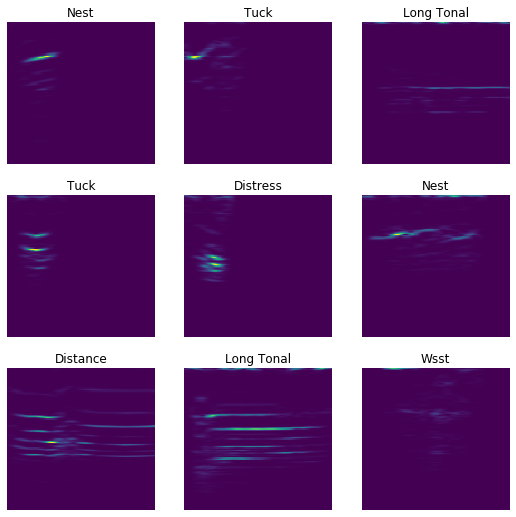

In [21]:
dls.show_batch()

## Fine tune a pretrained deep learning model

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.235697,1.764557,0.574780,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.909926,0.993910,0.287390,00:04


## Perform error analysis

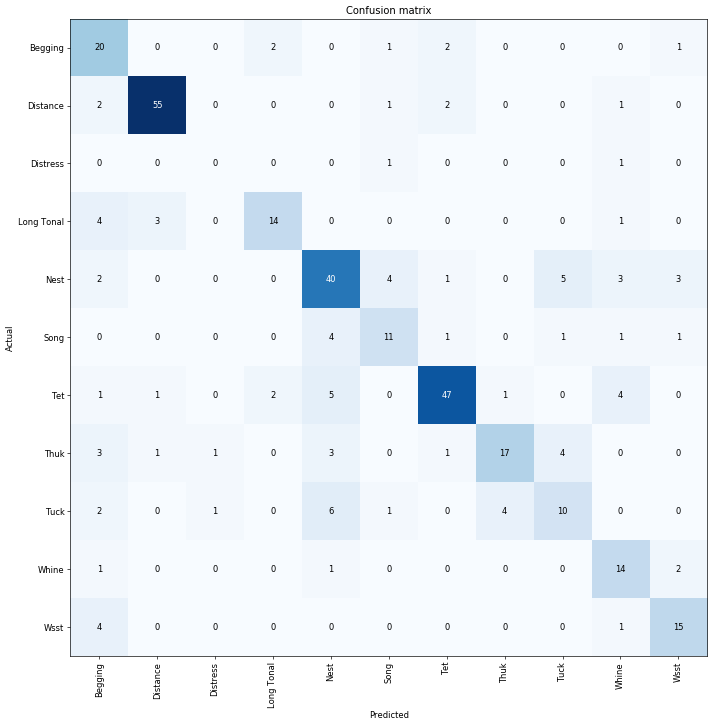

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)